In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os
from src import config

In [2]:
features_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "memory_features_df.pkl"))
labels_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "memory_labels_df.pkl"))

In [3]:
# Remove all the features that contains 'Post' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('Post')]
features_df.head()

,Blinks_Per_Minute,Blinks_Duration_Mean,Blinks_Duration_Median,Blink_Variability,Blinks_Duration_Min,Blinks_Duration_Max,Fixations_Count,Fixations_Rate,Fixations_Duration_Mean,Fixations_Duration_Median,...,DVA_Min_Gaze_Pre,DVA_Sem_Gaze_Pre,DVA_AUC_Gaze_Pre,DVA_Mean_Fixations_Pre,DVA_Median_Fixations_Pre,DVA_Std_Fixations_Pre,DVA_Max_Fixations_Pre,DVA_Min_Fixations_Pre,DVA_Sem_Fixations_Pre,DVA_AUC_Fixations_Pre
0,12.342857,132.000000,129.0,67.549981,66.0,201.0,35.0,2.400000,333.771429,275.0,...,9.485436,0.114942,52474.278127,19.743823,24.670071,6.053553,25.457728,9.789465,1.563021,296.157339
1,NaN,NaN,NaN,NaN,NaN,NaN,46.0,3.154286,284.608696,267.0,...,2.614537,0.113426,62010.907977,19.295206,22.554525,6.835452,25.391660,3.181130,1.528453,385.904129
2,27.692308,130.000000,86.0,104.115321,64.0,312.0,30.0,2.769231,321.066667,264.0,...,5.844040,0.128652,36331.111637,16.405096,16.357059,6.786038,25.893978,6.629466,1.813645,229.671346
3,12.378223,72.666667,66.0,24.684678,52.0,100.0,52.0,3.575931,244.423077,217.0,...,11.783918,0.042936,62956.761877,19.795590,20.467621,2.385218,24.389404,16.085974,0.459035,534.480926
4,14.400000,79.000000,80.0,26.514147,52.0,105.0,25.0,2.000000,308.080000,223.0,...,0.581440,0.076724,64937.572461,15.083811,16.300744,5.101190,22.310018,1.558471,1.087577,331.843843


In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Columns: 102 entries, Blinks_Per_Minute to DVA_AUC_Fixations_Pre
dtypes: float64(102)
memory usage: 1.6 MB


In [5]:
labels_df.head()

,mem
series_id,
0,1
1,1
2,1
3,1
4,1


In [6]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 2039
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   mem     2040 non-null   int64
dtypes: int64(1)
memory usage: 31.9 KB


Data Cleaning

how many missing values are there in each column? show the top 10

In [7]:
features_df.isna().sum(axis=0).sort_values(ascending=False).head(10)

Pupil radius_Fixations_ReEntry_Mean_Diff_Pre    460
Pupil radius_Fixations_First_Diff_Pre           460
Blinks_Duration_Max                             397
Blinks_Duration_Mean                            397
Blinks_Per_Minute                               397
Blinks_Duration_Min                             397
Blinks_Duration_Median                          397
Blink_Variability                               397
onset_Mean_Saccades_Start_In_RoI_Pre            347
onset_Median_Saccades_Start_In_RoI_Pre          347
dtype: int64

Remove columns with more than 30% missing values

In [8]:
features_df = features_df.loc[:, features_df.isna().sum(axis=0) < 0.3 * features_df.shape[0]]

In [9]:
features_df.isna().sum(axis=0).sort_values(ascending=False).head(10)

Pupil radius_Fixations_ReEntry_Mean_Diff_Pre    460
Pupil radius_Fixations_First_Diff_Pre           460
Blinks_Duration_Max                             397
Blinks_Duration_Mean                            397
Blinks_Per_Minute                               397
Blinks_Duration_Min                             397
Blinks_Duration_Median                          397
Blink_Variability                               397
onset_Mean_Saccades_Start_In_RoI_Pre            347
onset_Median_Saccades_Start_In_RoI_Pre          347
dtype: int64

how many missing values are there in each row? show the top 10

In [10]:
features_df.isna().sum(axis=1).sort_values(ascending=False).head(10)

1164    102
496      49
1706     49
1452     49
682      49
1167     49
1789     49
1290     49
890      49
1761     49
dtype: int64

Remove rows with more than 50% missing values

In [11]:
features_df = features_df.loc[features_df.isna().sum(axis=1) < 0.5 * features_df.shape[1], :]
# remove the corresponding rows from y_train
labels_df = labels_df.loc[labels_df.index.isin(features_df.index)]

In [12]:
features_df.isna().sum(axis=1).sort_values(ascending=False).head(10)

1033    49
1257    49
1279    49
1706    49
1290    49
319     49
890     49
1886    49
1317    49
1111    49
dtype: int64

Train/Test Split (before any preprocessing is done)

In [13]:
series_id_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "memory_series_id_df.pkl"))

# Create a list of unique subject IDs
subject_ids = series_id_df[config.SUBJECT].unique()

# Shuffle the list of subject IDs randomly
random = np.random
random.seed(1)
random.shuffle(subject_ids)

# Split the list of subject IDs into two parts
train_subject_ids = subject_ids[:int(len(subject_ids)*0.9)]
print(len(train_subject_ids))
test_subject_ids = subject_ids[int(len(subject_ids)*0.9):]
print(len(test_subject_ids))

# Subset the data based on the split list of subject IDs
train_data = series_id_df[series_id_df[config.SUBJECT].isin(train_subject_ids)]
test_data = series_id_df[series_id_df[config.SUBJECT].isin(test_subject_ids)]

X_train = features_df[features_df.index.isin(train_data.index)]
X_test = features_df[features_df.index.isin(test_data.index)]
y_train = labels_df[labels_df.index.isin(train_data.index)]
y_test = labels_df[labels_df.index.isin(test_data.index)]

30
4


In [14]:
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(features_df,
#                                                     labels_df['mem'],
#                                                     random_state=420,
#                                                     test_size=0.2)

In [15]:
X_train.head()

,Blinks_Per_Minute,Blinks_Duration_Mean,Blinks_Duration_Median,Blink_Variability,Blinks_Duration_Min,Blinks_Duration_Max,Fixations_Count,Fixations_Rate,Fixations_Duration_Mean,Fixations_Duration_Median,...,DVA_Min_Gaze_Pre,DVA_Sem_Gaze_Pre,DVA_AUC_Gaze_Pre,DVA_Mean_Fixations_Pre,DVA_Median_Fixations_Pre,DVA_Std_Fixations_Pre,DVA_Max_Fixations_Pre,DVA_Min_Fixations_Pre,DVA_Sem_Fixations_Pre,DVA_AUC_Fixations_Pre
0,12.342857,132.000000,129.0,67.549981,66.0,201.0,35.0,2.400000,333.771429,275.0,...,9.485436,0.114942,52474.278127,19.743823,24.670071,6.053553,25.457728,9.789465,1.563021,296.157339
1,NaN,NaN,NaN,NaN,NaN,NaN,46.0,3.154286,284.608696,267.0,...,2.614537,0.113426,62010.907977,19.295206,22.554525,6.835452,25.391660,3.181130,1.528453,385.904129
2,27.692308,130.000000,86.0,104.115321,64.0,312.0,30.0,2.769231,321.066667,264.0,...,5.844040,0.128652,36331.111637,16.405096,16.357059,6.786038,25.893978,6.629466,1.813645,229.671346
3,12.378223,72.666667,66.0,24.684678,52.0,100.0,52.0,3.575931,244.423077,217.0,...,11.783918,0.042936,62956.761877,19.795590,20.467621,2.385218,24.389404,16.085974,0.459035,534.480926
4,14.400000,79.000000,80.0,26.514147,52.0,105.0,25.0,2.000000,308.080000,223.0,...,0.581440,0.076724,64937.572461,15.083811,16.300744,5.101190,22.310018,1.558471,1.087577,331.843843


Fill missing values with the mean of the column

In [16]:
# fill inf values with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

X_train = X_train.fillna(X_train.mean()) # fill missing values with the mean of the column or zero ? features_df.mean()
X_test = X_test.fillna(X_train.mean())

Remove columns with low variance (threshold = 5%)

In [17]:
from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 0.05
thresholder = VarianceThreshold(threshold=0.05)

# Fit the thresholder to the data
thresholder.fit(X_train)

# Get the indices of the columns that are retained
feature_idx = thresholder.get_support(indices=True)

# Create a list of the names of the retained columns
feature_names = X_train.columns[feature_idx]

# Subset the dataframe to include only the selected columns
X_train = X_train[feature_names]
X_test = X_test[feature_names]

Remove highly correlated features

In [18]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

How many features are left?

In [19]:
X_train.shape

(1799, 67)

Balancing the dataset

In [20]:
y_train.value_counts()

mem
1      1327
0       472
dtype: int64

SMOTE

In [21]:
# from imblearn.over_sampling import SMOTE
# 
# sm = SMOTE(random_state=420)
# X_train, y_train = sm.fit_resample(X_train, y_train)

Random Oversampling

In [22]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=420)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [23]:
y_train.value_counts()

mem
0      1327
1      1327
dtype: int64

Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

# Create separate StandardScaler instances
scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# Fit on Training Data (!)
scaler_x.fit(X_train.values)
# scaler_y.fit(y_train.values.reshape(-1, 1))

# Transform both training and testing data
X_train_scaled = scaler_x.transform(X_train.values)
X_test_scaled = scaler_x.transform(X_test.values)
y_train = y_train.values.reshape(-1, 1).flatten()
y_test = y_test.values.reshape(-1, 1).flatten()

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

PCA

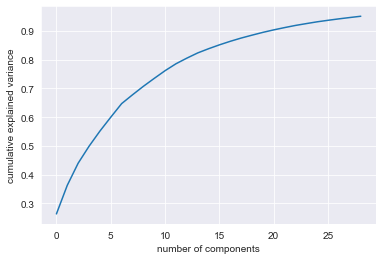

In [25]:
pca = PCA(n_components=0.95).fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [26]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [27]:
X_train_pca

array([[-6.96168959e-01, -2.62422548e-03,  9.50017742e-01, ...,
         3.55081974e-01, -1.62624675e-01,  6.66426802e-02],
       [ 2.01488361e+00, -3.90594937e+00,  3.22964121e+00, ...,
        -1.08185813e+00, -1.55853959e-01,  4.27180208e-01],
       [-3.27101347e+00,  1.86368518e+00,  1.02200505e+00, ...,
         1.02469867e-01, -2.17547365e-01,  1.70569487e-01],
       ...,
       [-3.91477396e+00,  2.19873329e+00,  2.44557580e-01, ...,
        -1.96828250e-01, -7.16317757e-02,  5.98017545e-02],
       [ 2.51388415e+00, -5.85628089e+00,  3.49224301e+00, ...,
        -1.23454867e+00, -4.22060634e-01,  6.52337045e-01],
       [-3.34433820e+00,  2.94395778e+00,  6.41470195e-01, ...,
         1.58337641e-01, -1.66964967e-01,  1.65357452e-01]])

LDA

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

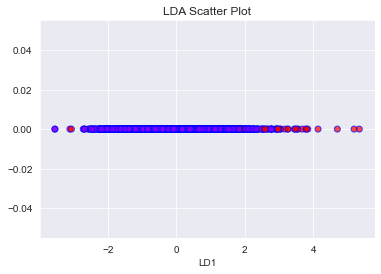

In [29]:
# Create a scatter plot of the transformed data
plt.scatter(X_train_lda, np.zeros(len(X_train_lda)), c=y_train, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.xlabel('LD1')
plt.title('LDA Scatter Plot')
plt.show()

In [30]:
X_train_preprocessed = X_train_scaled
X_test_preprocessed = X_test_scaled

Classification models

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model_name, y_true, y_pred):
    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(model_name)
    # Print the evaluation metrics
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("ROC-AUC score:", round(roc_auc, 2))

    # Compute the confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Create a heatmap visualization of the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")

    # Show the plot
    plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV

Logistic Regression model

In [33]:
from sklearn.linear_model import LogisticRegression

# Define the range of values for each hyperparameter
C = np.linspace(0.01, 1, 15)
PENALTY = ['l1', 'l2']
SOLVER = ['liblinear', 'saga']

PARAM_GRID  = {
    'C': C,
    'penalty': PENALTY,
    'solver': SOLVER
}

# Create the logistic regression estimator
estimator = LogisticRegression(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

KeyboardInterrupt: 

In [ ]:
# Get the best estimator
log_reg_best_estimator = model_searcher.best_estimator_
y_test_pred = log_reg_best_estimator.predict(X_test_preprocessed)

evaluate_model("Logistic Regression (test data)", y_test, y_test_pred)

Gradient Boosting model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the range of values for each hyperparameter
LEARNING_RATE = np.linspace(0.01, 0.5, 10)
MAX_DEPTH = range(2, 5)
N_ESTIMATORS = range(100, 180, 15)


PARAM_GRID  = {
    'learning_rate': LEARNING_RATE,
    'max_depth': MAX_DEPTH,
    'n_estimators': N_ESTIMATORS
}

# Create the gradient boosting estimator
estimator = GradientBoostingClassifier(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

In [ ]:
# Get the best estimator
gb_best_estimator = model_searcher.best_estimator_
y_test_pred = gb_best_estimator.predict(X_test_preprocessed)

evaluate_model("Gradient Boosting (test data)", y_test, y_test_pred)

Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the range of values for each hyperparameter
N_ESTIMATORS = range(50, 140, 15)
MAX_DEPTH = range(2, 6)
MIN_SAMPLES_SPLIT = range(2, 4)
MIN_SAMPLES_LEAF = range(1, 4)

PARAM_GRID  = {
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH,
    'min_samples_split': MIN_SAMPLES_SPLIT,
    'min_samples_leaf': MIN_SAMPLES_LEAF
}

# Create the random forest estimator
estimator = RandomForestClassifier(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

In [ ]:
rf_best_estimator = model_searcher.best_estimator_
y_test_pred = rf_best_estimator.predict(X_test_preprocessed)

evaluate_model("Random Forest (test data)", y_test, y_test_pred)

XGBoost model

In [ ]:
from xgboost import XGBClassifier

# Define the range of values for each hyperparameter
LEARNING_RATE = np.linspace(0.05, 0.5, 10)
MAX_DEPTH = range(1, 5)
N_ESTIMATORS = range(70, 150, 15)

PARAM_GRID  = {
    'learning_rate': LEARNING_RATE,
    'max_depth': MAX_DEPTH,
    'n_estimators': N_ESTIMATORS
}

# Define the ratio for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Create a XGBoost classifier with specific parameters
estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight=ratio)


# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

Evaluate the best model on the test data

In [ ]:
xgb_best_estimator = model_searcher.best_estimator_
y_test_pred = xgb_best_estimator.predict(X_test_preprocessed)

evaluate_model("XGBoost (test data)", y_test, y_test_pred)

TabNetClassifier with automatic hyperparameters tuning

In [ ]:
!pip install pytorch-tabnet
!pip install optuna

In [ ]:
# Convert Pandas DataFrame to NumPy array
X_train_np = X_train_preprocessed.values
X_test_np = X_test_preprocessed.values

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
from sklearn.metrics import mean_squared_error

# Define objective function for optuna
def objective(trial):
    # Generate hyperparameter search space
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 1, 19),
        'gamma': trial.suggest_float('gamma', 0.1, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 10),
        'n_shared': trial.suggest_int('n_shared', 1, 10),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.0001, 0.1),
        # 'optimizer_fn': torch.optim.Adam,
        # 'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
        # 'mask_type': 'entmax',
        # 'scheduler_params': dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),
        # 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
        'verbose': 0
    }

    # Create TabNetClassifier object with hyperparameters from optuna
    classifier = TabNetClassifier(**params)

    # Train and evaluate the model
    classifier.fit(X_train_np, y_train, eval_set=[(X_test_np, y_test)])
    val_preds = classifier.predict_proba(X_test_np)[:, 1]
    val_auc = roc_auc_score(y_test, val_preds)

    return val_auc

# Create optuna study
study = optuna.create_study(direction='maximize')

# Optimize hyperparameters using optuna
study.optimize(objective, n_trials=42, timeout=600)

# Get best hyperparameters from optuna
best_params = study.best_trial.params

# Train final model with best hyperparameters
tabnet = TabNetClassifier(**best_params)
tabnet.fit(X_train_np, y_train)
best_params

Evaluate the best model on the test data

In [ ]:
# Evaluate final model on test set
y_test_pred = tabnet.predict(X_test_np)
evaluate_model("Tabnet (test data)", y_test, y_test_pred)

The best model is Gradient Boosting

In [ ]:
the_best_model_ever = tabnet

Feature importance

In [ ]:
feature_importances = pd.DataFrame(the_best_model_ever.feature_importances_,
                                   index = X_train_preprocessed.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances